# 6장. 텍스트와 시퀀스를 위한 딥러닝(Deep Learning for Text and Sequence)

* 이 장에서는 텍스트(단어의 시퀀스 또는 문자의 시퀀스), 시계열 또는 일반적인 시퀀스(sequence) 데이터를 처리할 수 있는 딥러닝 모델을 살펴보겠습니다. 시퀀스 데이터를 처리하는 기본적인 딥러닝 모델은 **순환 신경망**(recurrent neural network)과  **1D 컨브넷**(1D convnet) 두 가지입니다. 1D 컨브넷은 이전 장에서 다룬 2D 컨브넷의 1차원 버전입니다. 이 장에서는 두 가지 방법을 모두 다루겠습니다.

* 다름 애플리케이션들이 이런 알고리즘을 사용합니다.
    * 문서 분류나 시계열 분류, 예를 들어 글의 주체나 책의 저자 식별하기
    * 시계열 비교, 예를 들어 두 문서나 두 주식 가격이 얼마나 밀접하게 관련이 있는지 추정하기
    * 시퀀스-투-시퀀스 학습, 예를 들어 영어 문장을 프랑스어로 변환하기
    * 감성 분석, 예를 들어 어떤 지역의 최근 날씨 데이터가 주어졌을 때 향후 날씨 예측하기
    
* 이 장의 예제는 2개의 문제를 집중하여 다룹니다. 앞서 다루어 보았던 IMDB 데이터셋의 감성 분석과 기온 예측입니다. 이 두 작업에서 사용한 기법들은 위에 나열한 것은 물론 많은 애플리케이션들과 관련되어 있습니다.

## 6.1 텍스트 데이터 다루기(Handling text data)

* 다른 모든 신경망과 마찬가지로 텍스트 원본을 입력으로 사용하지 못합니다. 딥러닝 모델은 수치형 텐서만 다룰 수 있습니다. 텍스트를 수치형 텐서로 변환하는 과정을 텍스트 벡터화(vectorizing text)라고 합니다. 여기서는 여러 가지 방식이 있습니다.
    * 텍스트를 단어로 나누고 각 단어를 하나의 벡터로 변환합니다.
    * 텍스트를 문자로 나누고 각 문자를 하나의 벡터로 변환합니다.
    * 텍스트에서 단어나 문자의 n-그램(n-gram)을 추출하여 각 n-그램을 하나의 벡터로 변환합니다. n-그램은 연속된 단어나 문자의 그룹으로 텍스트에서 단어나 문자를 하나씩 이동하면서 추출합니다.
    
* 텍스트를 나누는 이런 단위(단어, 문자, n-그램)를 토큰(token)이라고 합니다. 그리고 텍스트를 토콘으로 나누는 작업을 토큰화(tokenization)라고 합니다. 모든 텍스트 벡터화 과정은 어떤 종류의 토큰화를 적용하고 생성된 토큰에 수치형 벡터를 연결하는 것으로 이루어집니다.

### 6.1.1 단어와 문자의 원-핫 인코딩(One-Hot Encoding of word and text)

* 원-핫 인코딩은 토큰을 벡터로 변환하는 가장 일반적이고 기본적인 방법입니다. 3장에서 IMDB와 로이터 예제에서 이를 보았습니다(단어의 원-핫 인코딩을 사용했습니다). 모든 단어에 고유한 정수 인덱스를 부여하고 이 정수 인덱스 i를 크기가 N(어휘 사전의 크기)인 이진 벡터로 변환합니다. 이 벡터는 i번째 원소만 1이고 나머지는 모두 0입니다.

* 물론 원-핫 인코딩은 문자 수준에서도 적용할 수 있습니다. 원-핫 인코딩이 무엇이고 어떻게 구현하는지 명확하게 설명하기 위해 단어와 문자에 대한 간단한 예를 만들었습니다.

In [8]:
# 단어 수준의 원-핫 인코딩(간단한 예):
import numpy as np

# 초기 데이터: 각 원소가 샘플입니다
# (이 예에서 하나의 샘플이 하나의 문장입니다. 하지만 문서 전체가 될 수도 있습니다)
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# 데이터에 있는 모든 토큰의 인덱스를 구축합니다
token_index = {}
for sample in samples:
    # split() 메서드를 사용해 샘플을 토큰으로 나눕니다.
    # 실전에서는 구둣점과 특수 문자도 사용합니다.
    for word in sample.split():
        if word not in token_index:
            # 단어마다 고유한 인덱스를 할당합니다.
            token_index[word] = len(token_index) + 1
            # 인덱스 0은 사용하지 않습니다.

# 샘플을 벡터로 변환합니다.
# 각 샘플에서 max_length 까지 단어만 사용합니다.
max_length = 10

# 결과를 저장할 배열입니다
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

In [9]:
# 문자 수준 원-핫 인코딩(간단한 예):
import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable  # 출력 가능한 모든 아스키(ASCII) 문자
token_index = dict(zip(characters, range(1, len(characters) + 1)))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample[:max_length]):
        index = token_index.get(character)
        results[i, j, index] = 1.

* 케라스에는 원본 텍스트 데이터를 단어 또는 문자 수준의 원-핫 인코딩으로 변환해주는 유틸리티가 있습니다. 특수 문자를 제거하거나 빈도가 높은 N개의 단어만을 선택(입력 벡터 공간이 너무 커지지 않도록 하기 위한 일반적인 제한 방법입니다)하는 등 여러 가지 중요한 기능들이 있기 때문에 이 유틸리티를 사용하는 것이 좋습니다.

In [10]:
# 케라스를 사용한 단어 수준의 원-핫 인코딩하기
from tensorflow.keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# 가장 빈도가 높은 1,000개의 단어만 선택하도록 Tokenizer 객체를 만듭니다.
tokenizer = Tokenizer(num_words=1000)
# 단어 인덱스를 구축합니다.
tokenizer.fit_on_texts(samples)

# 문자열을 정수 인덱스의 리스트로 변환합니다.
sequences = tokenizer.texts_to_sequences(samples)

# 직접 원-핫 이진 벡터 표현을 얻을 수 있습니다.
# 원-핫 인코딩 외에 다른 벡터화 방법들도 제공합니다!
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

# 계산된 단어 인덱스를 구합니다.
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9 unique tokens.


* 원-핫 인코딩의 변종 중 하나는 원-핫 해싱 기법입니다. 이 방식은 어휘 사전에 있는 고유한 토큰의 수가 너무 커서 모두 다루기 어려울 때 사용합니다. 각 단어에 명시적으로 인덱스를 할당하고 이 인덱스를 딕셔너리에 저장하는 대신에 단어를 해싱하여 고정된 크기의 벡터로 변환합니다. 일반적으로 간단한 해싱 함수를 사용합니다. 이 방식의 주요 장점은 명시적인 단어 인덱스가 필요 없기 때문에 메모리를 절약하고 온라인 방식으로 데이터를 인코딩할 수 있습니다(전체 데이터를 확인하지 않고 토큰을 생성할 수 있습니다). 한 가지 단점은 해시 충돌입니다. 두 개의 단어가 같은 해시를 만들면 이를 바라보는 머신 러닝 모델은 단어 사이의 차이를 인식하지 못합니다. 해싱 공간의 차원이 해싱될 고유 토큰의 전체 개수보다 훨씬 크면 해시 충돌의 가능성은 감소합니다.

In [11]:
# 해싱 기법을 사용한 단어 수준의 원-핫 인코딩하기(간단한 예)
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# 단어를 크기가 1,000인 벡터로 저장합니다.
# 1,000개(또는 그이상)의 단어가 있다면 해싱 충돌이 늘어나고 인코딩의 정확도가 감소될 것입니다
dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        # 단어를 해싱하여 0과 1,000 사이의 랜덤한 정수 인덱스로 변환합니다.
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

### 6.1.2 단어 임베딩 사용하기
* 단어와 벡터를 연관짓는 강력하고 인기 있는 또 다른 방법은 단어 임베딩이라는 밀집 단어 벡터를 사용하는 것입니다. 원-핫 인코딩으로 만든 벡터는 희소하고(대부분 0으로 채워집니다) 고차원입니다(어휘 사전에 있는 단어의 수와 차원이 같습니다). 반면 단어 임베딩은 저차원의 실수형 벡터입니다(희소 벡터의 반대인 밀집 벡터입니다). 그림 6-2를 참고하세요. 원-핫 인코딩으로 얻은 단어 벡터와 달리 단어 임베딩은 데이터로부터 학습됩니다. 보통 256차원, 512차원 또는 큰 어휘 사전을 다룰 때는 1,024차원의 단어 임베딩을 사용합니다. 반면 원-핫 인코딩은 (20,000개의 토큰으로 이루어진 어휘 사전을 만들려면) 20,000차원 또는 그 이상의 벡터일 경우가 많습니다. 따라서 단어 임베딩이 더 많은 정보를 적은 차원에 저장합니다.

![word embeddings vs. one hot encoding](https://s3.amazonaws.com/book.keras.io/img/ch6/word_embeddings.png)

* 단어 임베딩을 만드는 방법은 두 가지입니다.

    * (문서 분류나 감성 예측과 같은) 관심 대상인 문제와 함께 단어 임베딩을 학습합니다. 이런 경우에는 랜덤한 단어 벡터로 시작해서 신경망의 가중치를 학습하는 것과 같은 방식으로 단어 벡터를 학습합니다.
    * 풀려는 문제가 아니고 다른 머신 러닝 작업에서 미리 계산된 단어 임베딩을 로드합니다. 이를 사전 훈련된 단어 임베딩이라고 합니다.
* 두 가지 모두 살펴보겠습니다.

### `Embedding` 층을 사용해 단어 임베딩 학습하기

* 단어와 밀집 벡터를 연관짓는 가장 간단한 방법은 랜덤하게 벡터를 선택하는 것입니다. 이 방식의 문제점은 임베딩 공간이 구조적이지 않다는 것입니다. 예를 들어 accurate와 exact 단어가 대부분 문장에서 비슷한 의미로 사용되지만 완전히 다른 임베딩을 가지게 됩니다. 심층 신경망이 이런 임의의 구조적이지 않은 임베딩 공간을 이해하기는 어렵습니다.

* 단어 벡터 사이에 조금 더 추상적이고 기하학적인 관계를 얻으려면 단어 사이에 있는 의미 관계를 반영해야 합니다. 단어 임베딩은 언어를 기하학적 공간에 매핑하는 것입니다. 예를 들어 잘 구축된 임베딩 공간에서는 동의어가 비슷한 단어 벡터로 임베딩될 것입니다. 일반적으로 두 단어 벡터 사이의 거리(L2 거리)는 이 단어 사이의 의미 거리와 관계되어 있습니다(멀리 떨어진 위치에 임베딩된 단어의 의미는 서로 다르고 반면 비슷한 단어들은 가까이 임베딩됩니다). 거리외에 임베딩 공간의 특정 방향도 의미를 가질 수 있습니다.

* 실제 단어 임베딩 공간에서 의미 있는 기하학적 변환의 일반적인 예는 '성별' 벡터와 '복수(plural)' 벡터입니다. 예를 들어 'king' 벡터에 'female' 벡터를 더하면 'queen' 벡터가 됩니다. 'plural' 벡터를 더하면 'kings'가 됩니다. 단어 임베딩 공간은 전형적으로 이런 해석 가능하고 잠재적으로 유용한 수천 개의 벡터를 특성으로 가집니다.

* 사람의 언어를 완벽하게 매핑해서 어떤 자연어 처리 작업에도 사용할 수 있는 이상적인 단어 임베딩 공간이 있을까요? 아마도 가능하겠지만 아직까지 이런 종류의 공간은 만들지 못했습니다. 사람의 언어에도 그런 것은 없습니다. 세상에는 많은 다른 언어가 있고 언어는 특정 문화와 환경을 반영하기 때문에 서로 동일하지 않습니다. 실제로 좋은 단어 임베딩 공간을 만드는 것은 문제에 따라 크게 달라집니다. 영어로 된 영화 리뷰 감성 분석 모델을 위한 완벽한 단어 임베딩 공간은 영어로 된 법률 문서 분류 모델을 위한 완벽한 임베딩 공간과 다를 것 같습니다. 특정 의미 관계의 중요성이 작업에 따라 다르기 때문입니다.

* 따라서 새로운 작업에는 새로운 임베딩을 학습하는 것이 타당합니다. 다행히 역전파를 사용해 쉽게 만들 수 있고 케라스를 사용하면 더 쉽습니다. `Embedding` 층의 가중치를 학습하면 됩니다.

In [12]:
# Embedding 층의 객체 생성하기(creating object of Embedding layer)
from tensorflow.keras.layers import Embedding

# Embedding 층은 적어도 두 개의 매개변수를 받습니다.
# 가능한 토큰의 개수(여기서는 1,000으로 단어 인덱스 최댓값 + 1입니다)와 임베딩 차원(여기서는 64)입니다
embedding_layer = Embedding(1000, 64)

`Embedding` 층을 (특정 단어를 나타내는) 정수 인덱스를 밀집 벡터로 매핑하는 딕셔너리로 이해하는 것이 가장 좋습니다. 정수를 입력으로 받아 내부 딕셔너리에서 이 정수에 연관된 벡터를 찾아 반환합니다. 딕셔너리 탐색은 효율적으로 수행됩니다.

`Embedding` 층은 크기가 `(samples, sequence_length)`인 2D 정수 텐서를 입력으로 받습니다. 각 샘플은 정수의 시퀀스입니다. 가변 길이의 시퀀스를 임베딩할 수 있습니다. 예를 들어 위 예제의 `Embedding` 층에 `(32, 10)` 크기의 배치(길이가 10인 시퀀스 32개로 이루어진 배치)나 `(64, 15)` 크기의 배치(길이가 15인 시퀀스 64개로 이루어진 배치)를 주입할 수 있습니다. 배치에 있는 모든 시퀀스는 길이가 같아야 하므로(하나의 텐서에 담아야 하기 때문에) 작은 길이의 시퀀스는 0으로 패딩되고 길이가 더 긴 시퀀스는 잘립니다.

`Embedding` 층은 크기가 `(samples, sequence_length, embedding_dimensionality)`인 3D 실수형 텐서를 반환합니다. 이런 3D 텐서는 RNN 층이나 1D 합성곱 층에서 처리됩니다(둘 다 이어지는 절에서 소개하겠습니다).

`Embedding` 층의 객체를 생성할 때 가중치(토큰 벡터를 위한 내부 딕셔너리)는 다른 층과 마찬가지로 랜덤하게 초기화됩니다. 훈련하면서 이 단어 벡터는 역전파를 통해 점차 조정되어 이어지는 모델이 사용할 수 있도록 임베팅 공간을 구성합니다. 훈련이 끝나면 임베딩 공간은 특정 문제에 특화된 구조를 많이 가지게 됩니다.

이를 익숙한 IMDB 영화 리뷰 감성 예측 문제에 적용해 보죠. 먼저 데이터를 준비합니다. 영화 리뷰에서 가장 빈도가 높은 10,000개의 단어를 추출하고(처음 이 데이터셋으로 작업했던 것과 동일합니다) 리뷰에서 20개 단어 이후는 버립니다. 이 네트워크는 10,000개의 단어에 대해 8 차원의 임베딩을 학습하여 정수 시퀀스 입력(2D 정수 텐서)를 임베딩 시퀀스(3D 실수형 텐서)로 바꿀 것입니다. 그 다음 이 텐서를 2D로 펼쳐서 분류를 위한 `Dense` 층을 훈련하겠습니다.

In [8]:
# Embedding 층에 사용될 IMDB 데이터 로드하기
# Load IMDB Data to use Embedding layer
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

# 특성으로 사용할 단어의 수
max_features = 10000
# 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
maxlen = 20

# 정수 리스트로 데이터를 로드합니다.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 리스트를 (samples, maxlen) 크기의 2D 정수 텐서로 변환합니다.
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
c:\users\wnstj\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
c:\users\wnstj\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wit

In [14]:
# IMDB 데이터에 Embedding 층과 분류기 사용하기
# Using Embedding layer and classifier to IMDB data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

model = Sequential()
# 나중에 임베딩된 입력을 Flatten 층에서 펼치기 위해 Embedding 층에 input_length를 지정합니다.
model.add(Embedding(10000, 8, input_length=maxlen))
# Embedding 층의 출력 크기는 (samples, maxlen, 8)가 됩니다.

# 3D 임베딩 텐서를 (samples, maxlen * 8) 크기의 2D 텐서로 펼칩니다.
model.add(Flatten())

# 분류기를 추가합니다.
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 3s 2ms/step - loss: 0.6721 - acc: 0.6253 - val_loss: 0.6291 - val_acc: 0.6910
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5525 - acc: 0.7480 - val_loss: 0.5344 - val_acc: 0.7264
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4667 - acc: 0.7842 - val_loss: 0.5043 - 

#### 사전 훈련된 단어 임베딩 사용하기

* 이따금 훈련 데이터가 부족하면 작업에 맞는 단어 임베딩을 학습할 수 없습니다. 이럴 땐 어떻게 해야 할까요?

* 풀려는 문제와 함께 단어 임베딩을 학습하는 대신에 미리 계산된 임베딩 공간에서 임베딩 벡터를 로드할 수 있습니다. 이런 임베딩 공간은 뛰어난 구조와 유용한 성질을 가지고 있어서 언어 구조의 일반적인 측면을 잡아낼 수 있습니다. 자연어 처리에서 사전 훈련된 단어 임베딩을 사용하는 이유는 이미지 분류 문제에서 사전 훈련된 컨브넷을 사용하는 이유와 거의 동일합니다. 충분한 데이터가 없어서 자신만의 좋은 특성을 학습하지 못하지만 꽤 일반적인 특성이 필요할 때입니다. 이런 경우에는 다른 문제에서 학습한 특성을 재사용하는 것이 합리적입니다.

* 단어 임베딩은 일반적으로 (문장이나 문서에 같이 등장하는 단어를 관찰하는) 단어 출현 통계를 사용하여 계산됩니다. 여기에는 여러 가지 기법이 사용되는데 신경망을 사용하는 것도 있고 그렇지 않은 방법도 있습니다. 단어를 위해 밀집된 저차원 임베딩 공간을 비지도 학습 방법으로 계산하는 아이디어는 요슈아 벤지오 등이 2000년대 초에 조사했습니다. 연구나 산업 애플리케이션에 적용되기 시작된 것은 Word2vec 알고리즘이 등장한 이후입니다. 이 알고리즘은 2013년 구글의 토마스 미코로프가 개발하였으며 가장 유명하고 성공적인 단어 임베딩 방법입니다. Word2vec의 차원은 성별 같은 구체적인 의미가 있는 속성을 잡아냅니다.

* 케라스의 `Embedding` 층을 위해 내려받을 수 있는 미리 계산된 단어 임베딩 데이터베이스가 여럿 있습니다. Word2vec은 그 중 하나입니다. 인기 있는 또 다른 하나는 2014년 스탠포드 대학의 연구자들이 개발한 GloVe(Global Vectors for Word Representation)입니다. 이 임베딩 기법은 단어의 동시 출현 통계를 기록한 행렬을 분해하는 기법을 사용합니다. 이 개발자들은 위키피디아 데이터와 커먼 크롤 데이터에서 가져온 수백만 개의 영어 토큰에 대해서 임베딩을 미리 계산해 놓았습니다.

* GloVe 임베딩을 케라스 모델에 어떻게 사용하는지 알아보죠. Word2vec 임베딩이나 다른 단어 임베딩 데이터베이스도 방법은 같습니다. 앞서 보았던 텍스트 토큰화 기법도 다시 살펴보겠습니다. 원본 텍스트에서 시작해서 완전한 모델을 구성해 보겠습니다.

### 6.1.3 모든 내용을 적용하기: 원본 텍스트에서 단어 임베딩까지

* 앞서 만들었던 것과 비슷한 모델을 사용하겠습니다. 문장들을 벡터의 시퀀스로 임베딩하고 펼친 다음 그 위에 `Dense` 층을 훈련합니다. 여기서는 사전 훈련된 단어 임베딩을 사용하겠습니다. 케라스에 포함된 IMDB 데이터는 미리 토큰화가 되어 있습니다. 이를 사용하는 대신 원본 텍스트 데이터를 다운로딩해서 처음부터 시작하겠습니다.

#### 원본 IMDB 텍스트 다운로드하기

* 먼저 http://mng.bz/0tIo 에서 IMDB 원본 데이터셋을 다운로드하고 압축을 해제합니다.

* 훈련용 리뷰 하나를 문자열 하나로 만들어 훈련 데이터를 문자열의 리스트로 구성해 보죠. 리뷰 레이블(긍정/부정)도 `labels` 리스트로 만들겠습니다.

In [15]:
# IMDB 원본 데이터 전처리하기
# Preprocessing IMDB original data
import os

imdb_dir = '../data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

#### 데이터 토큰화

이전 절에서 소개한 개념을 사용해 텍스트를 벡터로 만들고 훈련 세트와 검증 세트로 나누겠습니다. 사전 훈련된 단어 임베딩은 훈련 데이터가 부족한 문제에 특히 유용합니다(그렇지 않으면 문제에 특화된 임베딩이 훨씬 성능이 좋습니다). 그래서 다음과 같이 훈련 데이터를 처음 200개의 샘플로 제한합니다. 이 모델은 200개의 샘플을 학습한 후에 영화 리뷰를 분류할 것입니다.

In [16]:
# IMDB 원본 데이터의 텍스트를 토큰화하기
# Tokenize text about IMDB original data
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # 100개 단어 이후는 버립니다
training_samples = 200  # 훈련 샘플은 200개입니다
validation_samples = 10000  # 검증 샘플은 10,000개입니다
max_words = 10000  # 데이터셋에서 가장 빈도 높은 10,000개의 단어만 사용합니다

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)

# 데이터를 훈련 세트와 검증 세트로 분할합니다.
# 샘플이 순서대로 있기 때문에 (부정 샘플이 모두 나온 후에 긍정 샘플이 옵니다) 
# 먼저 데이터를 섞습니다.
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (25000, 100)
레이블 텐서의 크기: (25000,)


#### GloVe 단어 임베딩 내려받기

https://nlp.stanford.edu/projects/glove 에서 2014년 영문 위키피디아를 사용해 사전에 계산된 임베딩을 내려받습니다. 이 파일의 이름은 glove.6B.zip이고 압축 파일 크기는 823MB입니다. 400,000만개의 단어(또는 단어가 아닌 토큰)에 대한 100차원의 임베딩 벡터를 포함하고 있습니다. datasets 폴더 아래에 파일 압축을 해제합니다.(이 저장소에는 이미 포함되어 있습니다)

#### 임베딩 전처리

압축 해제한 파일(.txt 파일)을 파싱하여 단어(즉 문자열)와 이에 상응하는 벡터 표현(즉 숫자 벡터)를 매핑하는 인덱스를 만듭니다.

In [17]:
# Glove 단어 임베딩 파일 파싱하기
# Parsing Glove word embedding files
import os
import numpy as np
glove_dir = '../data/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('%s개의 단어 벡터를 찾았습니다.' % len(embeddings_index))

400000개의 단어 벡터를 찾았습니다.


* 그다음 `Embedding` 층에 주입할 수 있도록 임베딩 행렬을 만듭니다. 이 행렬의 크기는 `(max_words, embedding_dim)`이어야 합니다. 이 행렬의 `i`번째 원소는 (토큰화로 만든) 단어 인덱스의 `i`번째 단어에 상응하는 `embedding_dim` 차원 벡터입니다. 인덱스 `0`은 어떤 단어나 토큰도 아닐 경우를 나타냅니다.

In [18]:
# GloVe 단어 임베딩 행렬 준비하기
# Preparing a Glove word embedding matrix
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # 임베딩 인덱스에 없는 단어는 모두 0이 됩니다.
            embedding_matrix[i] = embedding_vector

#### 모델 정의하기

이전과 동일한 구조의 모델을 사용하겠습니다.

In [19]:
# 모델 정의하기(Define a model)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


#### 모델에 GloVe 임베딩 로드하기

`Embedding` 층은 하나의 가중치 행렬을 가집니다. 이 행렬은 2D 부동 소수 행렬이고 각 `i`번째 원소는 `i`번째 인덱스에 상응하는 단어 벡터입니다. 간단하네요. 모델의 첫 번째 층인 `Embedding` 층에 준비된 GloVe 행렬을 로드하세요.

In [20]:
# 사전 훈련된 단어 임베딩을 Embedding 층에 로드하기
# Load pre-trained word embeddings to Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

* 추가적으로 Embedding 층을 동결합니다(trainable 속성을 False로 설정합니다). 사전 훈련된 컨브넷 특성을 사용할 때와 같은 이유입니다. 모델의 일부는 (Embedding 층처럼) 사전 훈련되고 다른 부분은 (최상단 분류기처럼) 랜덤하게 초기화되었다면 훈련하는 동안 사전 훈련된 부분이 업데이트되면 안됩니다. 이미 알고 있던 정보를 모두 잃게 됩니다. 랜덤하게 초기화된 층에서 대량의 그래디언트 업데이트가 발생하면 이미 학습된 특성을 오염시키기 때문입니다.

#### 모델 훈련과 평가

모델을 컴파일하고 훈련합니다.

In [21]:
# 훈련과 평가하기(Training and Evaluation)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 2s 188ms/step - loss: 1.7236 - acc: 0.5350 - val_loss: 0.7237 - val_acc: 0.5134
Epoch 2/10
7/7 [==============================] - 1s 139ms/step - loss: 0.7043 - acc: 0.6350 - val_loss: 1.0212 - val_acc: 0.4950
Epoch 3/10
7/7 [==============================] - 1s 148ms/step - loss: 0.6065 - acc: 0.6450 - val_loss: 0.7859 - val_acc: 0.5145
Epoch 4/10
7/7 [==============================] - 1s 141ms/step - loss: 0.4106 - acc: 0.8100 - val_loss: 0.7467 - val_acc: 0.5308
Epoch 5/10
7/7 [==============================] - 1s 151ms/step - loss: 0.3904 - acc: 0.8200 - val_loss: 1.0206 - val_acc: 0.5092
Epoch 6/10
7/7 [==============================] - 1s 174ms/step - loss: 0.1830 - acc: 0.9600 - val_loss: 0.9907 - val_acc: 0.5195
Epoch 7/10
7/7 [==============================] - 1s 157ms/step - loss: 0.1123 - acc: 0.9600 - val_loss: 0.9762 - val_acc: 0.5230
Epoch 8/10
7/7 [==============================] - 1s 168ms/step - loss: 0.1091 - acc: 0.97

* 이제 모델의 성능을 그래프로 그려보겠습니다.

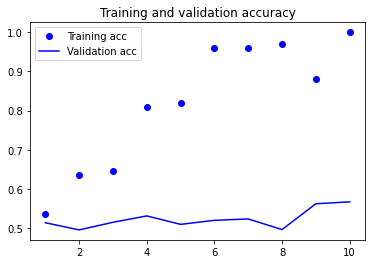

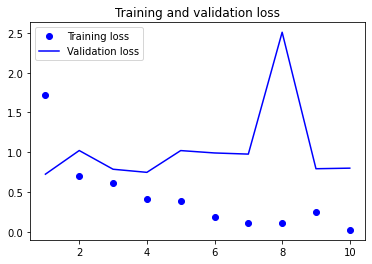

In [22]:
# 결과 그래프 그리기
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* 이 모델은 과대적합이 빠르게 시작됩니다. 훈련 샘플 수가 작기 때문에 놀라운 일은 아닙니다. 같은 이유로 검증 정확도와 훈련 정확도 사이에 차이가 큽니다. 검증 정확도는 50% 후반을 달성한 것 같습니다.

* 훈련 샘플 수가 적기 때문에 어떤 샘플 200개를 선택했는지에 따라 성능이 크게 좌우됩니다. 여기서는 샘플들을 랜덤하게 선택했습니다. 만약 선택한 샘플에서 성능이 나쁘면 예제를 위해서 랜덤하게 200개의 샘플을 다시 추출하세요(실전에서는 훈련 데이터를 고르지 않습니다).

* 사전 훈련된 단어 임베딩을 사용하지 않거나 임베딩 층을 동결하지 않고 같은 모델을 훈련할 수 있습니다. 이런 경우 해당 작업에 특화된 입력 토큰의 임베딩을 학습할 것입니다. 데이터가 풍부하게 있다면 사전 훈련된 단어 임베딩보다 일반적으로 훨씬 성능이 높습니다. 여기서는 훈련 샘플이 200개뿐이지만 한 번 시도해 보죠.

In [24]:
# 사전 훈련된 단어 임베딩을 사용하지 않고 같은 모델 훈련하기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 2s 217ms/step - loss: 0.6951 - acc: 0.4900 - val_loss: 0.6922 - val_acc: 0.5071
Epoch 2/10
7/7 [==============================] - 1s 157ms/step - loss: 0.4869 - acc: 0.9750 - val_loss: 0.6957 

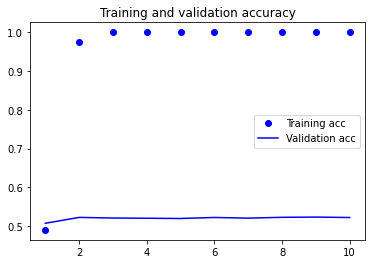

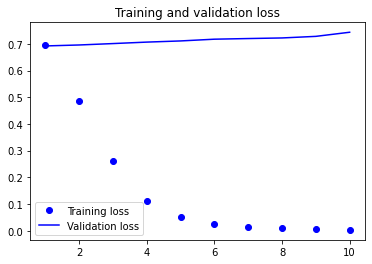

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* 검증 정확도는 50% 초반에 멈추어 있습니다. 이 예제에서는 사전 훈련된 단어 임베딩을 사용하는 것이 임베딩을 함께 훈련하는 것보다 낫습니다. 훈련 샘플의 수를 늘리면 금새 상황이 바뀝니다. 연습삼아 한 번 확인해 보세요.

* 훈련 샘플의 수를 2000개로 늘려서 확인해 보겠습니다.

In [26]:
training_samples = 2000
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [27]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10
63/63 [==============================] - 2s 37ms/step - loss: 0.6361 - acc: 0.6045 - val_loss: 0.6749 - val_acc: 0.6069
Epoch 2/10
63/63 [==============================] - 2s 34ms/step - loss: 0.1599 - acc: 0.9850 - val_loss: 0.6299 - val_acc: 0.6633
Epoch 3/10
63/63 [==============================] - 2s 31ms/step - loss: 0.0198 - acc: 1.0000 - val_loss: 0.6610 - val_acc: 0.6869
Epoch 4/10
63/63 [==============================] - 2s 35ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.6922 - val_acc: 0.7002
Epoch 5/10
63/63 [==============================] - 2s 32ms/step - loss: 1.4465e-04 - acc: 1.0000 - val_loss: 0.7454 - val_acc: 0.7106
Epoch 6/10
63/63 [==============================] - 2s 36ms/step - loss: 1.0088e-05 - acc: 1.0000 - val_loss: 0.8300 - val_acc: 0.7132
Epoch 7/10
63/63 [==============================] - 2s 31ms/step - loss: 9.0039e-07 - acc: 1.0000 - val_loss: 0.8951 - val_acc: 0.7189
Epoch 8/10
63/63 [==============================] - 2s 32ms/step - loss

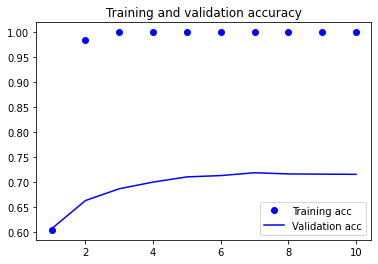

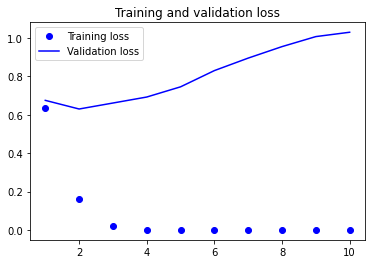

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* 훈련 샘플의 수를 늘리니 단어 임베딩을 같이 훈련하는 모델의 검증 정확도가 70%를 넘었습니다.

* 마지막으로 테스트 데이터에서 모델을 평가해 보죠. 먼저 테스트 데이터를 토큰화해야 합니다.

In [29]:
# 테스트 데이터 토큰화하기(tokenize test data)
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

* 그다음 이 절의 첫 번째 모델을 로드하고 평가합니다.

In [30]:
# 테스트 세트에서 모델 평가하기
# Evaluate the model on test set
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 3s 3ms/step - loss: 0.8000 - acc: 0.5683


[0.7999987602233887, 0.5682799816131592]

* 테스트 정확도는 겨우 50% 정도입니다. 적은 수의 훈련 샘플로 작업하는 것은 어려운 일이군요!

## 6.2 순환 신경망 이해하기(Understanding recurrent neural networks)

In [ ]:
# 의사코드로 표현한 RNN
# RNN which expressed by pseudocode
# 타임스텝 t의 상태입니다.
state_t = 0
# 시퀀스의 원소를 반복합니다.
for input_t in input_sequence:
     output_t = f(input_t, state_t)
     # 출력은 다음 반복을 위한 상태가 됩니다.
     state_t = output_t

* f함수는 입력과 상태를 출력으로 변환합니다. 이를 2개의 행렬 W와 U 그리고 편향 벡터를 사용하는 변환으로 바꿀 수 있습니다. 피드포워드 네트워크의 완전 연결 층에서 수행되는 변환과 비슷합니다.

In [ ]:
# 좀 더 자세한 의사코드로 표현한 RNN
# RNN which expressed by a more detailed pseudocode
# 타임스텝 t의 상태입니다.
state_t = 0
# 시퀀스의 원소를 반복합니다.
for input_t in input_sequence:
     output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
     # 출력은 다음 반복을 위한 상태가 됩니다.
     state_t = output_t

* 완벽하게 설명하기 위해 간단한 RNN의 정방향 계산을 넘파으로 구현해 보죠.

In [26]:
# 넘파이로 구현한 간단한 RNN
# Simple RNN which implemented by numpy
import numpy as np
timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))

state_t = np.zeros((output_features,))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs:
     output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
     # 이 출력을 리스트에 저장합니다.   
     successive_outputs.append(output_t)
     # 다음 타임스텝을 위해 네트워크의 상태를 업데이트합니다.
     state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### 6.2.1 케라스의 순환 층(Circulating layer of keras)
* 넘파이로 간단하게 구현한 과정이 실제 케라스의 SimpleRNN 층에 해당합니다.

In [31]:
from tensorflow.keras.layers import SimpleRNN

* `SimpleRNN`이 한 가지 다른 점은 넘파이 예제처럼 하나의 시퀀스가 아니라 다른 케라스 층과 마찬가지로 시퀀스 배치를 처리한다는 것입니다. 즉, `(timesteps, input_features)` 크기가 아니라 `(batch_size, timesteps, input_features)` 크기의 입력을 받습니다.

* 케라스에 있는 모든 순환 층과 동일하게 `SimpleRNN`은 두 가지 모드로 실행할 수 있습니다. 각 타임스텝의 출력을 모은 전체 시퀀스를 반환하거나(크기가 `(batch_size, timesteps, output_features)`인 3D 텐서), 입력 시퀀스에 대한 마지막 출력만 반환할 수 있습니다(크기가 `(batch_size, output_features)`인 2D 텐서). 이 모드는 객체를 생성할 때 `return_sequences` 매개변수로 선택할 수 있습니다. 예제를 살펴보죠.

In [32]:
# SimpleRNN을 사용하여 마지막 타임스텝의 출력을 얻기
# Get the output of the last timestep by using SimpleRNN for studying circulating layer of keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


* 다음 예는 전체 상태 시퀀스를 반환합니다.

In [33]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


* 네트워크의 표현력을 증가시키기 위해 여러 개의 순환 층을 차례대로 쌓는 것이 유용할 때가 있습니다. 이런 설정에서는 중간 층들이 전체 출력 시퀀스를 반환하도록 설정해야 합니다.

In [34]:
# SimpleRNN을 사용하여 마지막 타임스텝의 출력을 얻기
# Get the output of the last timestep by using SimpleRNN
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # 맨 위 층만 마지막 출력을 반환합니다.
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


* 이제 IMDB 영화 리뷰 분류 문제에 적용해 보죠. 먼저 데이터를 전처리합니다.

In [9]:
# IMDB 데이터 전처리하기
# Preprocessing IMDB data
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # 특성으로 사용할 단어의 수
maxlen = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
batch_size = 32

print('데이터 로딩...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), '훈련 시퀀스')
print(len(input_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train 크기:', input_train.shape)
print('input_test 크기:', input_test.shape)

데이터 로딩...
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
input_train 크기: (25000, 500)
input_test 크기: (25000, 500)


* `Embedding` 층과 `SimpleRNN` 층을 사용해 간단한 순환 네트워크를 훈련시켜 보겠습니다

In [36]:
# Embedding 층과 SimpleRNN 층을 사용한 모델 훈련하기
# training model by using Embedding layer and SimpleRNN layer
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 30s 182ms/step - loss: 0.6531 - acc: 0.6018 - val_loss: 0.5071 - val_acc: 0.7840
Epoch 2/10
157/157 [==============================] - 28s 180ms/step - loss: 0.3992 - acc: 0.8329 - val_loss: 0.3795 - val_acc: 0.8410
Epoch 3/10
157/157 [==============================] - 28s 178ms/step - loss: 0.2866 - acc: 0.8867 - val_loss: 0.3778 - val_acc: 0.8530
Epoch 4/10
157/157 [==============================] - 28s 178ms/step - loss: 0.2254 - acc: 0.9160 - val_loss: 0.3687 - val_acc: 0.8414
Epoch 5/10
157/157 [==============================] - 28s 177ms/step - loss: 0.1643 - acc: 0.9409 - val_loss: 0.4231 - val_acc: 0.8164
Epoch 6/10
157/157 [==============================] - 28s 178ms/step - loss: 0.1161 - acc: 0.9603 - val_loss: 0.3913 - val_acc: 0.8594
Epoch 7/10
157/157 [==============================] - 29s 183ms/step - loss: 0.0774 - acc: 0.9750 - val_loss: 0.5108 - val_acc: 0.8068
Epoch 8/10
157/157 [==============================] - 2

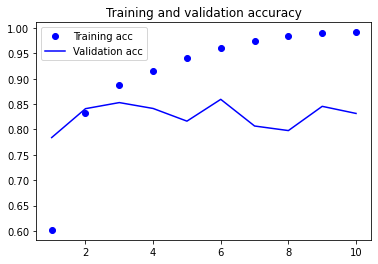

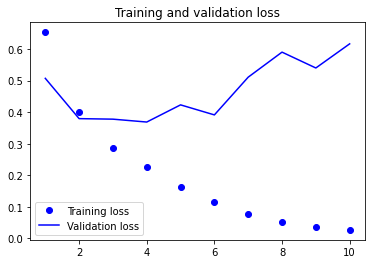

In [37]:
# 결과 그래프 그리기
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* 3장에서 이 데이터셋을 사용한 첫 번째 모델에서 얻은 테스트 정확도는 87%였습니다. 안타깝지만 간단한 순환 네트워크는 이 기준 모델보다 성능이 높지 않습니다(85% 정도의 검증 정확도를 얻었습니다). 이런 원인은 전체 시퀀스가 아니라 처음 500개의 단어만 입력에 사용했기 때문입니다. 이 RNN은 기준 모델보다 얻은 정보가 적습니다. 다른 이유는 `SimpleRNN`이 텍스트와 같이 긴 시퀀스를 처리하는데 적합하지 않기 때문입니다. 더 잘 작동하는 다른 순환 층이 있습니다. 조금 더 고급 순환 층을 살펴보죠.

### 6.2.3 케라스를 사용한 LSTM 예제

* 이제 실제적인 관심사로 이동해 보죠. LSTM 층으로 모델을 구성하고 IMDB 데이터에서 훈련해 보겠습니다(그림 6-16과 6-17 참조). 이 네트워크는 조금 전 `SimpleRNN`을 사용했던 모델과 비슷합니다. LSTM 층은 출력 차원만 지정하고 다른 (많은) 매개변수는 케라스의 기본값으로 남겨 두었습니다. 케라스는 좋은 기본값을 가지고 있어서 직접 매개변수를 튜닝하는 데 시간을 쓰지 않고도 거의 항상 어느정도 작동하는 모델을 얻을 수 있습니다.

In [39]:
# 케라스에서 LSTM층 사용하여 IMDB문제의 훈련과
# 검증 손실, 그리고 훈련과 검증 정확도 그리기
# graph training and validation loss, and training and validation
# accuracy of IMDB problem by using LSTM layer in keras
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 98s 585ms/step - loss: 0.5274 - acc: 0.7554 - val_loss: 0.5720 - val_acc: 0.7284
Epoch 2/10
157/157 [==============================] - 90s 571ms/step - loss: 0.3025 - acc: 0.8810 - val_loss: 0.3132 - val_acc: 0.8722
Epoch 3/10
157/157 [==============================] - 90s 571ms/step - loss: 0.2358 - acc: 0.9083 - val_loss: 0.3395 - val_acc: 0.8640
Epoch 4/10
157/157 [==============================] - 92s 585ms/step - loss: 0.2069 - acc: 0.9255 - val_loss: 0.3106 - val_acc: 0.8850
Epoch 5/10
157/157 [==============================] - 92s 586ms/step - loss: 0.1749 - acc: 0.9356 - val_loss: 0.3015 - val_acc: 0.8762
Epoch 6/10
157/157 [==============================] - 96s 609ms/step - loss: 0.1570 - acc: 0.9426 - val_loss: 0.3439 - val_acc: 0.8826
Epoch 7/10
157/157 [==============================] - 96s 610ms/step - loss: 0.1422 - acc: 0.9496 - val_loss: 0.4076 - val_acc: 0.8762
Epoch 8/10
157/157 [==============================] - 9

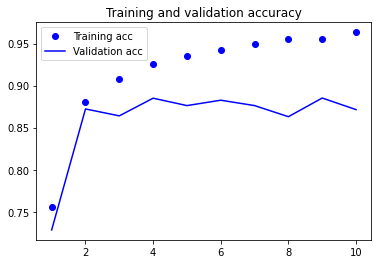

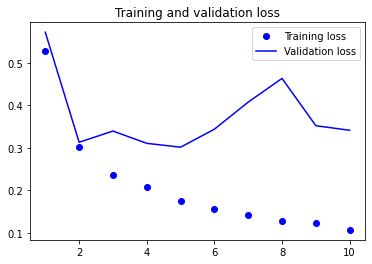

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 6.3  순환 신경망의 고급 사용법

* 이 절에서는 순환 신경망의 성능과 일반화 능력을 향상시키기 위한 세 가지의 고급 기술을 살펴보겠습니다. 이 절을 마칠 때면 케라스에서 순환 신경망을 사용하는 대부분의 방법을 알게 될 것입니다. 온도 예측 문제로 세 가지 개념을 모두 시연해 보겠습니다. 이 시계열 데이터는 건물 옥상에 설치된 센서에서 취득한 온도, 기압, 습도 같은 데이터입니다. 이 데이터를 사용하여 마지막 데이터 포인트에서부터 24시간 이후의 온도를 예측하겠습니다. 이 문제는 시계열 데이터에서 일반적으로 나타나는 여러 가지 어려운 점을 가지고 있습니다. 전형적이고 꽤 도전적인 문제입니다.

* 다음 기법들을 적용하겠습니다.

    * 순환 드롭아웃 : 순환 층에서 과대적합을 방지하기 위해 케라스에 내장되어 있는 드롭아웃을 사용합니다.
    * 순환 층 스태킹 : 네트워크의 표현 능력을 증가시킵니다(대신 계산 비용이 많이 듭니다).
    * 양방향 순환 층 : 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지시킵니다.

### 6.3.1 기온 예측 문제
* 지금까지 다룬 시퀀스 데이터는 IMDB 데이터셋이나 로이터 데이터셋과 같은 텍스트 데이터입니다. 시퀀스 데이터는 이런 언어 처리 분야뿐만 아니라 훨씬 많은 문제에서 등장합니다. 이 절에 있는 모든 예제는 날씨 시계열 데이터셋을 사용합니다. 이 데이터는 독일 예나 시에 있는 막스 플랑크 생물지구화학 연구소( http://www.bgc-jena.mpg.de/wetter/ )의 지상 관측소에서 수집한 것입니다.

* 이 데이터셋에는 수년간에 걸쳐 (기온, 기압, 습도, 풍향 등과 같은) 14개의 관측치가 10분마다 기록되어 있습니다. 원본 데이터는 2003년부터 기록되어 있지만 이 예제에서는 2009~2016년 사이의 데이터만 사용합니다. 이 데이터셋은 시계열 수치 데이터를 다루는 법을 익히는 데 안성맞춤입니다. 최근 데이터(몇 일치 데이터 포인트)를 입력으로 사용해 모델을 만들고 24시간 이후의 기온을 예측하겠습니다.

* 데이터를 살펴보죠.

In [14]:
# 예나의 날씨 데이터셋 조사하기
# Researching Jena's weather dataset
import os

data_dir = '../data/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


* 420,551개 데이터 전체를 넘파이 배열로 바꿉니다.

In [15]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

* 예를 들어 다음은 시간에 따른 기온(섭씨) 그래프입니다.

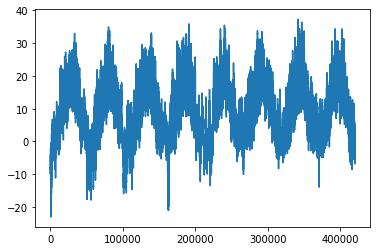

In [43]:
# 시계열 온도 그래프 그리기
# draw time series temperature graph
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # 온도(섭씨)
plt.plot(range(len(temp)), temp)
plt.show()

* 이 그래프에서 온도에 주기성이 있다는 것을 잘 볼 수 있습니다.

* 다음은 기간을 좁혀서 처음 10일간의 온도 데이터를 나타낸 그래프입니다. 10분마다 데이터가 기록되므로 하루에 총 144개의 데이터 포인트가 있습니다

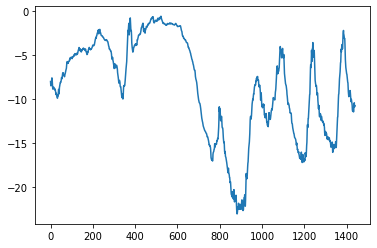

In [44]:
# 처음 10일간 온도 그래프 그리기
# graph temperature for first ten days
plt.plot(range(1440), temp[:1440])
plt.show()

* 이 그래프에서 일별 주기성을 볼 수 있습니다. 특히 마지막 4일간을 보면 확실합니다. 이 데이터는 아주 추운 겨울 중 10일입니다.

* 지난 몇 달간의 데이터를 사용해 다음 달의 평균 온도를 예측하는 문제는 쉬운 편입니다. 연간 데이터 주기성은 안정적이기 때문입니다. 하지만 하루 하루 데이터를 살펴보면 온도 변화는 매우 불안정합니다. 일자별 수준의 시계열 데이터를 예측할 수 있을까요? 직접 확인해 보겠습니다.

### 6.3.2 데이터 준비(Preparing the data)

* 이 문제의 정확한 정의는 다음과 같습니다. `lookback` 타임스텝(하나의 타임스텝은 10분입니다)만큼 이전으로 돌아가서 매 `steps` 타임스텝마다 샘플링합니다. 이 데이터를 바탕으로 `delay` 타임스텝 이후의 온도를 예측할 수 있을까요? 사용할 변수는 다음과 같습니다.

    * `lookback = 1440` : 10일 전 데이터로 돌아갑니다.
    * `steps = 6` : 한 시간마다 데이터 포인트 하나를 샘플링합니다.
    * `delay = 144` : 24시간이 지난 데이터가 타깃이 됩니다.

* 시작하기 전에 두 가지 작업을 처리해야 합니다:

    * 신경망에 주입할 수 있는 형태로 데이터를 전처리합니다. 데이터가 이미 수치형이므로 추가적인 벡터화가 필요하지 않습니다. 하지만 데이터에 있는 각 시계열 특성의 범위가 서로 다릅니다(예를 들어 온도는 일반적으로 -20도에서 +30도 사이이고, 밀리바(mb)로 측정된 기압은 1,000 근처의 값입니다). 각 시계열 특성을 개별적으로 정규화하여 비슷한 범위를 가진 작은 값으로 바꾸겠습니다.
    * float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출하는 파이썬 제너레이터를 만듭니다. 이 데이터셋에 있는 샘플은 중복이 많습니다(샘플 `N`과 샘플 `N + 1`은 대부분 타임스텝이 비슷합니다). 모든 샘플을 각기 메모리에 적재하는 것은 낭비가 심하므로 대신에 원본 데이터를 사용해 그때 그때 배치를 만들겠습니다.

* 각 시계열 특성에 대해 평균을 빼고 표준 편차로 나누어 전처리합니다. 처음 200,000개 타임스텝을 훈련 데이터로 사용할 것이므로 전체 데이터에서 200,000개만 사용하여 평균과 표준 편차를 계산합니다.

In [45]:
# 데이터 정규화하기
# Normalizing data
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

* 다음은 여기서 사용할 제너레이터입니다. 이 제너레이터 함수는 `(samples, targets)` 튜플을 반복적으로 반환합니다. `samples`는 입력 데이터로 사용할 배치이고 `targets`은 이에 대응되는 타깃 온도의 배열입니다. 이 제너레이터 함수는 다음과 같은 매개변수가 있습니다:

    * `data` : 코드 6-32에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
    * `lookback` : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
    * `delay` : 타깃으로 사용할 미래의 타임스텝
    * `min_index`와 `max_index` : 추출할 타임스텝의 범위를 지정하기 위한 `data` 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용합니다.
    * `shuffle` : 샘플을 섞을지 시간 순서대로 추출할지 결정합니다.
    * `batch_size` : 배치의 샘플 수
    * `step` : 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정하겠습니다.

In [46]:
# 시계열 데이터와 타깃을 반환하는 제너레이터 함수
# Generator function that returns time series data and targets
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

* 이제 generator 함수를 사용해 훈련용, 검증용, 테스트용으로 세 개의 제너레이터를 만들어 보죠. 각 제너레이터는 원본 데이터에서 다른 시간대를 사용합니다. 훈련 제너레이터는 처음 200,000개 타임스텝을 사용하고 검증 제너레이터는 그 다음 100,000개를 사용하고 테스트 제너레이터는 나머지를 사용합니다.

In [47]:
# 훈련, 검증, 테스트 제너레이터 준비하기
# Preparing training, validation, and test generator
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### 6.3.3 상식 수준의 기준점
* 블랙 박스 같은 딥러닝 모델을 사용하여 온도 예측 문제를 풀기 전에 간단한 상식 수준의 해법을 시도해 보겠습니다. 이는 정상 여부 확인을 위한 용도고 고수준 머신 러닝 모델이라면 뛰어넘어야 할 기준점을 만듭니다. 이런 상식 수준의 해법은 알려진 해결책이 없는 새로운 문제를 다루어야 할 때 유용합니다. 일부 클래스가 월등히 많아 불균형한 분류 문제가 고전적인 예입니다. 데이터셋 클래스 A의 샘플이 90%, 클래스 B의 샘플이 10%가 있다면, 이 분류 문제에 대한 상식 수준의 접근법은 새로운 샘플을 항상 클래스 'A'라고 예측하는 것입니다. 이 분류기는 전반적으로 90%의 정확도를 낼 것입니다. 머신 러닝 기반의 모델이라면 90% 이상을 달성해야 유용하다고 볼 수 있습니다. 이따금 이런 기본적인 기준점을 넘어서기가 아주 어려운 경우가 있습니다.
* 이 경우 온도 시계열 데이터는 연속성이 있고 일자별로 주기성을 가진다고 가정할 수 있습니다(오늘 온도는 내일 온도와 비슷할 가능성이 높습니다). 그렇기 때문에 상식 수준의 해결책은 지금으로부터 24시간 후 온도는 지금과 동일하다고 예측하는 것입니다. 이 방법을 평균 절댓값 오차(MAE, Mean Average Error)로 평가해 보겠습니다.
```python
np.mean(np.abs(preds - targets))
```
* 다음은 평가를 위한 반복 루프입니다.

In [48]:
# 상식적인 기준 모델의 MAE 계산하기
# Caculate MAE in common-sense reference model
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
evaluate_naive_method()

0.2897359729905486


* 출력된 MAE는 0.29입니다. 이 온도 데이터는 평균이 0이고 표준 편차가 1이므로 결과값이 바로 와닿지는 않습니다. 평균 절댓값 오차 0.29에 표준 편차를 곱하면 섭씨 2.57℃가 됩니다.

In [49]:
# MAE를 섭씨 단위로 변환하기(Converting MAE to Celsius)
celsius_mae = 0.29 * std[1]

### 6.3.4 기본적인 머신 러닝 방법
* 머신 러닝 모델을 시도하기 전에 상식 수준의 기준점을 세워 놓았습니다. 비슷하게 RNN처럼 복잡하고 연산 비용이 많이 드는 모델을 시도하기 전에 간단하고 손쉽게 만들 수 있는 머신 러닝 모델(예를 들어 소규모의 완전 연결 네트워크)을 먼저 만드는 것이 좋습니다. 이를 바탕으로 더 복잡한 방법을 도입하는 근거가 마련되고 실제적인 이득도 얻게 될 것입니다.
* 다음 코드는 데이터를 펼쳐서 2개의 Dense 층을 통과시키는 완전 연결 네트워크를 보여 줍니다. 전형적인 회귀 문제이므로 마지막 Dense 층에 활성화 함수를 두지 않았습니다. 손실 함수는 MAE입니다. 상식 수준의 방법에서 사용한 것과 동일한 데이터와 지표를 사용했으므로 결과를 바로 비교해 볼 수 있습니다.

In [50]:
# 완전 연결 모델을 훈련하고 평가하기
# Tranining and evaluating fully connected models
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

c:\users\wnstj\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 22s 42ms/step - loss: 1.4866 - val_loss: 0.5995
Epoch 2/20
500/500 [==============================] - 21s 43ms/step - loss: 0.4642 - val_loss: 0.3742
Epoch 3/20
500/500 [==============================] - 26s 52ms/step - loss: 0.3086 - val_loss: 0.3602
Epoch 4/20
500/500 [==============================] - 23s 47ms/step - loss: 0.2699 - val_loss: 0.3114
Epoch 5/20
500/500 [==============================] - 24s 48ms/step - loss: 0.2555 - val_loss: 0.3073
Epoch 6/20
500/500 [==============================] - 27s 53ms/step - loss: 0.2454 - val_loss: 0.3096
Epoch 7/20
500/500 [==============================] - 24s 48ms/step - loss: 0.2394 - val_loss: 0.3071
Epoch 8/20
500/500 [==============================] - 24s 48ms/step - loss: 0.2335 - val_loss: 0.3215
Epoch 9/20
500/500 [==============================] - 23s 47ms/step - loss: 0.2284 - val_loss: 0.3389
Epoch 10/20
500/500 [==============================] - 24s 49ms/step - loss: 0.224

* 훈련 손실과 검증 손실의 그래프를 그려 보죠.

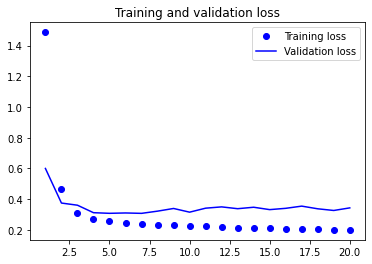

In [51]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

[간단한 완전 연결 네트워크에서 예나 온도 예측 문제의 훈련 손실과 검증 손실(Loss of training and verification of the example and temperature prediction problem in a simple fully connected network)]

* 일부 검증 손실은 학습을 사용하지 않은 기준점에 가깝지만 안정적이지 못합니다. 앞서 기준 모델을 만든 것이 도움이 됩니다. 이 문제는 기준 모델의 성능을 앞지르기가 쉽지 않습니다. 우리가 적용한 상식에는 머신 러닝 모델이 찾지 못한 핵심 정보가 많이 포함되어 있습니다.

* 간단하고 괜찮은 성능을 내는 모델(상식 수준의 기준 모델)이 데이터와 타깃을 매핑할 수 있다면 왜 훈련한 모델은 이를 찾지 못하고 성능이 낮을까요? 훈련 과정이 찾는 것은 간단한 이 모델이 아니기 때문입니다. 문제 해결을 위해 탐색하는 모델의 공간, 즉 가설 공간은 우리가 매개변수로 설정한 두 개 층을 가진 네트워크의 모든 가능한 가중치의 조합입니다. 이 네트워크는 이미 매우 복잡합니다. 복잡한 모델 공간에서 해결책을 탐색할 때 간단하고 괜찮은 성능을 내는 모델은 찾지 못할 수 있습니다. 심지어 기술적으로 봤을 때 이 가설 공간에 포함되어 있을 때 조차도 말이죠. 이것이 일반적으로 머신 러닝이 가진 심각한 제약 사항입니다. 학습 알고리즘이 특정한 종류의 간단한 모델을 찾도록 하드코딩되지 않았다면, 모델 파라미터를 학습하는 방법은 간단한 문제를 위한 간단한 해결책을 찾지 못할 수 있습니다.

### 6.3.5 첫 번째 순환 신경망
* 첫 번째 완전 연결 네트워크는 잘 작동하지 않았습니다. 그렇다고 이 문제에 머신 러닝이 적합하지 않다는 뜻은 아닙니다. 앞선 모델은 시계열 데이터를 펼쳤기 때문에 입력 데이터에서 시간 개념을 잃어버렸습니다. 그 대신 인과 관계와 순서가 의미 있는 시퀀스 데이터를 그대로 사용해 보겠습니다. 이런 시퀀스 데이터에 아주 잘 들어맞는 순환 시퀀스 처리 모델을 시도해 보겠습니다. 이 모델은 앞선 모델과 달리 데이터 포인터의 시간 순서를 사용합니다.
* 이전 절에서 소개한 `LSTM` 층 대신에 2014년에 정준영 등이 개발한 `GRU` 층을 사용하겠습니다. GRU(Gated Recurrent Unit) 층은 LSTM과 같은 원리로 작동하지만 조금 더 간결하고 그래서 계산 비용이 덜 듭니다(LSTM 만큼 표현 학습 능력이 높지는 않을 수 있습니다). 계산 비용과 표현 학습 능력 사이의 트레이드오프(trade-off)는 머신 러닝 어디에서나 등장합니다.

In [53]:
# GRU를 사용한 모델을 훈련하고 평가하기
# Training and evaluating models by using GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 154s 298ms/step - loss: 0.3060 - val_loss: 0.2717
Epoch 2/20
500/500 [==============================] - 154s 308ms/step - loss: 0.2843 - val_loss: 0.2682
Epoch 3/20
500/500 [==============================] - 152s 304ms/step - loss: 0.2773 - val_loss: 0.2660
Epoch 4/20
500/500 [==============================] - 146s 292ms/step - loss: 0.2744 - val_loss: 0.2636
Epoch 5/20
500/500 [==============================] - 119s 237ms/step - loss: 0.2681 - val_loss: 0.2638
Epoch 6/20
500/500 [==============================] - 119s 239ms/step - loss: 0.2638 - val_loss: 0.2613
Epoch 7/20
500/500 [==============================] - 118s 236ms/step - loss: 0.2606 - val_loss: 0.2710
Epoch 8/20
500/500 [==============================] - 118s 236ms/step - loss: 0.2569 - val_loss: 0.2669
Epoch 9/20
500/500 [==============================] - 119s 239ms/step - loss: 0.2518 - val_loss: 0.2711
Epoch 10/20
500/500 [==============================] - 119s 239m

* 결과를 확인해 보죠.

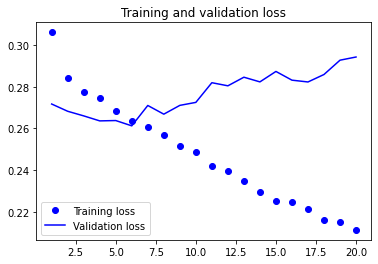

In [54]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

[GRU를 사용한 예나 온도 예측 작업의 훈련 손실과 검증 손실]

* 훨씬 좋군요! 상식 수준의 모델을 크게 앞질렀습니다. 이 그림은 시퀀스를 펼쳐서 처리하는 완전 연결 네트워크에 비해서 순환 네트워크가 이런 종류의 작업에 훨씬 뛰어나다는 것과 머신 러닝의 가치를 보여줍니다.

* 새로운 검증 MAE는 0.265 이하(크게 과대적합되기 시작하는 곳)이고 정규화되기 전인 섭씨로 복원하면 MAE는 2.35°C입니다. 초기 에러 2.57°C보다는 확실히 낫지만 더 개선할 수 있을 것 같습니다.

### 6.3.6 과대적합을 감소하기 위해 순환 드롭아웃 사용하기
* 훈련 손실과 검증 손실 곡선을 보면 모델이 과대적합인지 알 수 있습니다. 몇 번의 에포크 이후에 훈련 손실과 검증 손실이 현저하게 벌어지기 시작합니다. 이런 현상을 해결하기 위해 잘 알려진 드롭아웃 기법을 이미 보았습니다. 훈련 데이터를 층에 주입할 때 데이터에 있는 우연한 상관관계를 깨뜨리기 위해 입력 층의 유닛을 랜덤하게 끄는 기법입니다. 순환 신경망에 드롭아웃을 올바르게 적용하는 방법은 간단하지 않습니다. 순환 층 이전에 드롭아웃을 적용하면 규제에 도움이 되는 것보다 학습에 더 방해되는 것으로 오랫동안 알려졌습니다. 2015년 야린 갈이 베이지안 딥러닝에 관한 박사 논문에서 순환 네트워크에 적절하게 드롭아웃을 사용하는 방법을 알아 내었습니다. 타임스텝마다 랜덤하게 드롭아웃 마스크를 바꾸는 것이 아니라 동일한 드롭아웃 마스크(동일한 유닛의 드롭 패턴)를 모든 타임스텝에 적용해야 합니다. GRU이나 LSTM 같은 순환 게이트에 의해 만들어지는 표현을 규제하려면 순환 층 내부 계산에 사용된 활성화 함수에 타임스텝마다 동일한 드롭아웃 마스크를 적용해야 합니다(순환 드롭 아웃 마스크). 모든 타임스텝에 동일한 드롭아웃 마스크를 적용하면 네트워크가 학습 오차를 타임스템에 걸쳐 적절하게 전파시킬 것입니다. 타임스텝마다 랜덤한 드롭아웃 마스크를 적용하면 오차 신호가 전파되는 것을 방해하고 학습 과정에 해를 끼칩니다.

* 야린 갈은 케라스를 사용해 연구를 하였고 케라스 순환 층에 이 기능을 구현하는 데 도움을 주었습니다. 케라스에 있는 모든 순환 층은 두 개의 드롭아웃 매개변수를 가지고 있습니다. `dropout`은 층의 입력에 대한 드롭아웃 비율을 정하는 부동 소수 값입니다. `recurrent_dropout`은 순환 상태의 드롭아웃 비율을 정합니다. GRU 층에 드롭아웃과 순환 드롭아웃을 적용해 과대적합에 어떤 영향을 미치는지 살펴보겠습니다. 드롭아웃으로 규제된 네트워크는 언제나 완전히 수렴하는 데 더 오래 걸립니다. 에포크를 두 배 더 늘려 네트워크를 훈련하겠습니다.

In [55]:
# 드롭아웃 규제된 GRU를 사용한 모델을 훈련하고 평가하기
# Training and validation model which use dropout regulated GRU 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40, 
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 262s 501ms/step - loss: 0.3279 - val_loss: 0.2810
Epoch 2/40
500/500 [==============================] - 202s 404ms/step - loss: 0.3066 - val_loss: 0.2743
Epoch 3/40
500/500 [==============================] - 254s 509ms/step - loss: 0.2986 - val_loss: 0.2732
Epoch 4/40
500/500 [==============================] - 285s 570ms/step - loss: 0.2955 - val_loss: 0.2726
Epoch 5/40
500/500 [==============================] - 279s 559ms/step - loss: 0.2911 - val_loss: 0.2743
Epoch 6/40
500/500 [==============================] - 238s 477ms/step - loss: 0.2873 - val_loss: 0.2717
Epoch 7/40
500/500 [==============================] - 260s 520ms/step - loss: 0.2842 - val_loss: 0.2725
Epoch 8/40
500/500 [==============================] - 282s 564ms/step - loss: 0.2808 - val_loss: 0.2754
Epoch 9/40
500/500 [==============================] - 258s 517ms/step - loss: 0.2763 - val_loss: 0.2697
Epoch 10/40
500/500 [==============================] - 229s 457m

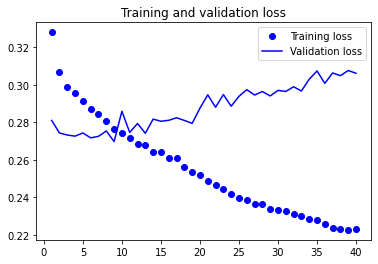

In [56]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* 성공이네요! 30번째 에포크까지 과대적합이 일어나지 않았습니다. 평가 점수는 안정적이지만 이전보다 더 나아지진 않았습니다.

### 6.3.7 스태킹 순환 층

* 과대적합은 더 이상 없지만 성능상의 병목이 있는 것 같으므로 네트워크의 용량을 늘려야 합니다. 일반적인 머신 러닝 작업 흐름을 기억하세요. (드롭아웃 등을 사용하여 과대적합을 줄이는 기본 단계를 거쳤다고 가정하고) 과대적합이 일어날 때까지 네트워크의 용량을 늘리는 것이 좋습니다. 너무 많이 과대적합되지 않는 한 아직 충분한 용량에 도달한 것이 아닙니다.

* 네트워크의 용량을 늘리려면 일반적으로 층에 있는 유닛의 수를 늘리거나 층을 더 많이 추가합니다. 순환 층 스태킹은 더 강력한 순환 네트워크를 만드는 고전적인 방법입니다. 예를 들어 구글 번역 알고리즘의 현재 성능은 7개의 대규모 LSTM 층을 쌓은 대규모 모델에서 나온 것입니다.

* 케라스에서 순환 층을 차례대로 쌓으려면 모든 중간 층은 마지막 타임스텝 출력만이 아니고 전체 시퀀스(3D 텐서)를 출력해야 합니다. `return_sequences=True`로 지정하면 됩니다.

In [57]:
# 드롭아웃으로 규제하고 스태킹한 GRU 모델을 훈련하고 평가하기
# Training and validation GRU model with regulated by dropout and stacked
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 540s 1s/step - loss: 0.3235 - val_loss: 0.2753
Epoch 2/40
500/500 [==============================] - 491s 982ms/step - loss: 0.3028 - val_loss: 0.2800
Epoch 3/40
500/500 [==============================] - 488s 976ms/step - loss: 0.2946 - val_loss: 0.2723
Epoch 4/40
500/500 [==============================] - 494s 989ms/step - loss: 0.2888 - val_loss: 0.2720
Epoch 5/40
500/500 [==============================] - 489s 978ms/step - loss: 0.2804 - val_loss: 0.2745
Epoch 6/40
500/500 [==============================] - 12635s 25s/step - loss: 0.2744 - val_loss: 0.2745
Epoch 7/40
500/500 [==============================] - 624s 1s/step - loss: 0.2678 - val_loss: 0.2774
Epoch 8/40
500/500 [==============================] - 42200s 85s/step - loss: 0.2645 - val_loss: 0.2811
Epoch 9/40
500/500 [==============================] - 646s 1s/step - loss: 0.2593 - val_loss: 0.2782
Epoch 10/40
500/500 [==============================] - 570s 1s/step - los

* 결과를 확인해 보죠.

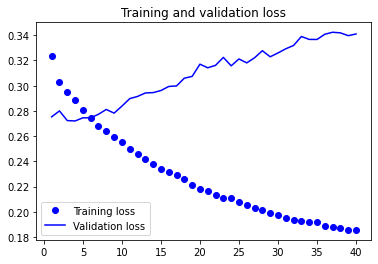

In [58]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* 층을 추가하여 성능을 조금 향상시켰지만 크지는 않습니다. 여기서 두 가지 결론을 얻을 수 있습니다:

    * 아직 충분히 과대적합을 만들지 못했기 때문에 검증 손실을 향상하기 위해서 층의 크기를 늘릴 수 있습니다. 하지만 적지 않은 계산 비용이 추가됩니다.
    * 층을 추가한 만큼 도움이 되지 않았으므로 여기서는 네트워크의 용량을 늘리는 것이 도움이 되지 않는다고 볼 수 있습니다.

### 6.3.8 양방향 RNN 사용하기(Use Bidirectional RNN)
* 이 절에서 소개할 마지막 기법은 양방향 RNN(bidirectional RNN)입니다. 양방향 RNN은 RNN의 한 변종이고 특정 작업에서 기본 RNN보다 훨씬 좋은 성능을 냅니다. 자연어 처리에서는 맥가이버 칼이라고 할 정도로 즐겨 사용됩니다.
* RNN은 특히 순서 또는 시간에 민감합니다. 즉, 입력 시퀀스의 타입스텝 순서대로 처리합니다. 타입스텝을 섞거나 거꾸로 하면 RNN이 시퀀스에서 학습하는 표현을 완전히 바꾸어 버립니다. 이는 온도 예측처럼 순서에 의미가 있는 문제에 잘 맞는 이유이기도 합니다. 양방향 RNN은 RNN이 순서에 민감하다는 성질을 사용합니다. 앞서 보았던 GRU나 LSTM 같은 RNN 두 개를 사용합니다. 각 RNN은 입력 시퀀스를 한 방향(시간의 순서나 반대 순서)으로 처리한 다음 각 표현을 합칩니다. 시퀀스를 양쪽 방향으로 처리하기 때문에 양방향 RNN은 단방향 RNN이 놓치기 쉬운 패턴을 감지할 수 있습니다.
* 놀랍게도 이 절에 있는 RNN 층이 시간의 순서대로 (오래된 타임스텝이 먼저 나오도록) 시퀀스를 처리하는 것은 근거 없는 결정입니다. 적어도 이 결정을 궁금해하지 않았습니다. 시간의 반대 방향으로 (최근 타임스텝이 먼저 나오도록) 입력 시퀀스를 처리하면 만족할만한 RNN 성능을 낼 수 있을까요? 실제 이렇게 해 보고 결과가 어떤지 확인해 보죠. 해야 할 일은 입력 시퀀스를 시간 차원을 따라 거꾸로 생성하는 데이터 제너레이터 만드는 것 뿐입니다(제너레이터 함수의 마지막 줄을 `yield samples[:, ::-1, :], targets`로 바꿉니다). 이 절의 첫 번째 예제와 동일하게 하나의 GRU 층을 가진 네트워크를 훈련합니다.

In [59]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [60]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 145s 264ms/step - loss: 0.4749 - val_loss: 0.4781
Epoch 2/20
500/500 [==============================] - 130s 261ms/step - loss: 0.4479 - val_loss: 0.4724
Epoch 3/20
500/500 [==============================] - 129s 259ms/step - loss: 0.3909 - val_loss: 0.4000
Epoch 4/20
500/500 [==============================] - 132s 265ms/step - loss: 0.3411 - val_loss: 0.3591
Epoch 5/20
500/500 [==============================] - 129s 259ms/step - loss: 0.3174 - val_loss: 0.3502
Epoch 6/20
500/500 [==============================] - 133s 265ms/step - loss: 0.2997 - val_loss: 0.3481
Epoch 7/20
500/500 [==============================] - 127s 255ms/step - loss: 0.2901 - val_loss: 0.3185
Epoch 8/20
500/500 [==============================] - 130s 260ms/step - loss: 0.2770 - val_loss: 0.3207
Epoch 9/20
500/500 [==============================] - 130s 261ms/step - loss: 0.2687 - val_loss: 0.3212
Epoch 10/20
500/500 [==============================] - 129s 258m

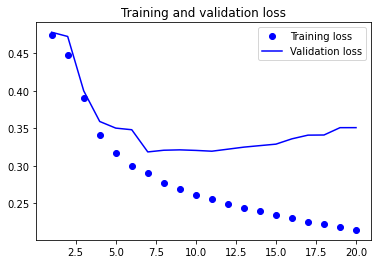

In [61]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

[거꾸로 뒤집힌 시퀀스로 훈련된 GRU 네트워크를 사용한 예나 온도 예측 문제의 훈련 손실과 검증 손실]

* 순서를 뒤집은 GRU는 상식 수준의 기준점보다도 성능이 낮습니다. 이 경우에는 시간 순서대로 처리하는 것이 중요한 역할을 합니다. 사실 이는 당연합니다. 기본적인 GRU 층은 먼 과거보다 최근 내용을 잘 기억합니다. 또한, 최근에 가까운 날씨 데이터 포인트일수록 오래된 데이터 포인트보다 예측에 유용합니다(상식 수준의 기준점이 꽤 강력한 이유입니다). 시간 순서대로 처리하는 네트워크가 거꾸로 처리하는 것보다 성능이 높아야만 합니다. 하지만 자연어 처리를 포함하여 다른 많은 문제에서는 그렇지 않습니다. 문장을 이해하는데 있어서 단어의 중요성은 단어가 문장 어디에 놓여 있는지에 따라 결정되지 않습니다. 같은 기법을 이전 절의 LSTM IMDB 예제에 적용해 보죠.

In [10]:
# 거꾸로 된 시퀀스를 사용한 LSTM을 훈련하고 평가하기
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# 특성으로 사용할 단어의 수
max_features = 10000
# 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
maxlen = 500

# 데이터 로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 시퀀스를 뒤집습니다
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# 시퀀스에 패딩을 추가합니다
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 182s 1s/step - loss: 0.4839 - acc: 0.7701 - val_loss: 0.3630 - val_acc: 0.8530
Epoch 2/10
157/157 [==============================] - 160s 1s/step - loss: 0.3116 - acc: 0.8830 - val_loss: 0.3407 - val_acc: 0.8728
Epoch 3/10
157/157 [==============================] - 162s 1s/step - loss: 0.2553 - acc: 0.9061 - val_loss: 0.3262 - val_acc: 0.8840
Epoch 4/10
157/157 [==============================] - 159s 1s/step - loss: 0.2135 - acc: 0.9240 - val_loss: 0.5045 - val_acc: 0.7932
Epoch 5/10
157/157 [==============================] - 173s 1s/step - loss: 0.1876 - acc: 0.9327 - val_loss: 0.3379 - val_acc: 0.8816
Epoch 6/10
157/157 [==============================] - 168s 1s/step - loss: 0.1720 - acc: 0.9401 - val_loss: 0.3853 - val_acc: 0.8682
Epoch 7/10
157/157 [==============================] - 172s 1s/step - loss: 0.1459 - acc: 0.9515 - val_loss: 0.4277 - val_acc: 0.8752
Epoch 8/10
157/157 [==============================] - 177s 1s/step - 

In [1]:
import tensorflow.keras
tensorflow.keras.__version__

'2.5.0'

* 시간 순서로 훈련한 LSTM과 거의 동일한 성능을 얻을 수 있습니다. 놀랍게도 이런 텍스트 데이터셋에는 순서를 뒤집어 처리하는 것이 시간 순서대로 처리하는 것과 거의 동일하게 잘 작동합니다. 이는 언어를 이해하는 데 단어의 순서가 중요하지만 결정적이지는 않다는 가정을 뒷받침합니다. 거꾸로 된 시퀀스에서 훈련한 RNN은 원래 시퀀스에서 훈련한 것과는 다른 표현을 학습합니다. 이와 비슷하게 시작할 때 죽고 마지막 날 태어나는 삶처럼 실제 세상의 시간이 거꾸로 흘러간다면 우리의 정신 세계가 달라질 것입니다. 머신 러닝에서 다른 표현이 유용하다면 항상 사용할 가치가 있습니다. 이 표현이 많이 다를수록 더 좋습니다. 이 표현이 데이터를 바라보는 새로운 시각을 제공하고 다른 방식에서는 놓칠 수 있는 데이터의 특징을 잡아냅니다. 이런 표현은 작업의 성능을 올리는 데 도움을 줍니다. 이것이 다음 장에서 살펴볼 앙상블의 개념입니다.

* 양방향 RNN은 이 아이디어를 사용하여 시간 순서대로 처리하는 RNN의 성능을 향상시킵니다. 입력 시퀀스를 양쪽 방향으로 바라보기 때문에, 드러나지 않은 다양한 표현을 얻어 시간 순서대로 처리할 때 놓칠 수 있는 패턴을 잡아 냅니다.

![bidirectional rnn](https://s3.amazonaws.com/book.keras.io/img/ch6/bidirectional_rnn.png)

* 케라스에서는 `Bidirectional` 층을 사용하여 양방향 RNN을 만듭니다. 이 클래스는 첫 번째 매개변수로 순환 층의 객체를 전달받습니다. `Bidirectional` 클래스는 전달받은 순환 층으로 새로운 두 번째 객체를 만듭니다. 하나는 시간 순서대로 입력 시퀀스를 처리하고 다른 하나는 반대 순서로 입력 시퀀스를 처리합니다. IMDB 감성 분석 문제에 이를 적용해 보죠.

In [3]:
from tensorflow.keras import backend as K
K.clear_session()

In [11]:
# 양방향 LSTM을 훈련하고 평가하기
# Training and evaluating two-way LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 266s 2s/step - loss: 0.5557 - acc: 0.7155 - val_loss: 0.3960 - val_acc: 0.8346
Epoch 2/10
157/157 [==============================] - 249s 2s/step - loss: 0.3421 - acc: 0.8694 - val_loss: 0.3447 - val_acc: 0.8804
Epoch 3/10
157/157 [==============================] - 248s 2s/step - loss: 0.2655 - acc: 0.9018 - val_loss: 0.3519 - val_acc: 0.8710
Epoch 4/10
157/157 [==============================] - 246s 2s/step - loss: 0.2287 - acc: 0.9166 - val_loss: 0.3534 - val_acc: 0.8802
Epoch 5/10
157/157 [==============================] - 246s 2s/step - loss: 0.1980 - acc: 0.9329 - val_loss: 0.3941 - val_acc: 0.8516
Epoch 6/10
157/157 [==============================] - 245s 2s/step - loss: 0.1768 - acc: 0.9376 - val_loss: 0.3148 - val_acc: 0.8820
Epoch 7/10
157/157 [==============================] - 246s 2s/step - loss: 0.1576 - acc: 0.9446 - val_loss: 0.3493 - val_acc: 0.8858
Epoch 8/10
157/157 [==============================] - 4788s 31s/step 

* 여기서 얻은 검증 정확도는 88% 정도로 이전 절에서 사용했던 일반 LSTM보다 조금 더 성능이 높습니다. 이 모델은 조금 더 일찍 과대적합되는 것 같습니다. 양방향 순환 층이 단방향 LSTM보다 모델 파라미터가 두 배 많기 때문에 놀라운 일은 아닙니다. 규제를 조금 추가한다면 양항뱡 순환 층을 사용하는 것이 이 작업에 더 적합해 보입니다.

* 이제 동일한 방식을 온도 예측 문제에 적용해 보죠.

In [16]:
# 양방향 GRU(Gated Recurrent Unit) 훈련하기
# Training Bidirectional GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizers=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

TypeError: Invalid keyword argument(s) in `compile`: {'optimizers'}

* 이 네트워크는 일반 GRU 층과 비슷한 성능을 냅니다. 이유는 쉽게 이해할 수 있습니다. 모든 예측 성능은 시간 순서대로 처리하는 네트워크의 절반에서 옵니다. 시간 반대 순서로 처리하는 절반은 이런 작업에 성능이 매우 좋지 않기 때문입니다(최근의 정보가 오래 전의 정보보다 훨씬 더 중요합니다).

### 6.3.9 더 나아가서

* 온도 예측 문제의 성능을 향상하기 위해 시도해 볼 수 있는 것들이 많이 있습니다.

    * 스태킹한 각 순환 층의 유닛 수를 조정합니다. 지금 설정은 대부분 임의로 한 것이라 최적화가 덜 되었을 것입니다.
    * `RMSprop` 옵티마이저가 사용한 학습률을 조정합니다.
    * `GRU` 대신 `LSTM` 층을 사용합니다.
    * 순환 층 위에 용량이 큰 완전 연결된 회귀 층을 사용합니다. 즉 유닛 수가 많은 `Dense` 층이나 `Dense` 층을 스태킹합니다.
    * 최종적으로 (검증 MAE 기준으로 봤을 때) 최선의 모델을 테스트 세트에서 확인해야 합니다. 이를 잊으면 검증 세트에 과대적합된 네트워크 구조를 만들게 될 것입니다.

* 늘 그렇듯이 딥러닝은 과학보다는 예술에 가깝습니다. 어떤 문제에 적합하거나 그렇지 않은 가이드라인은 제시할 수 있지만 결국 모든 문제는 다릅니다. 경험을 바탕으로 다른 전략들을 시도해 봐야 합니다. 현재는 문제를 해결하는 최선의 방법을 미리 알 수 있는 이론이 없습니다. 반복해서 시도해야 합니다.

### 6.3.10 요약

* 다음은 이번 절에서 배운 것들입니다.

    * 4장에서 처음 배웠던 것처럼 새로운 문제를 해결할 때는 선택한 지표에서 상식 수준의 기준점을 설정하는 것이 좋습니다. 기준점을 가지고 있지 않으면 실제 향상이 되었는지 알 수 없습니다.
    * 계산 비용을 추가할지 판단하기 위해서 비용이 비싼 모델 전에 간단한 모델을 시도합니다.
    * 시간 순서가 중요한 데이터가 있다면 순환 층이 적합합니다. 시계열 데이터를 펼쳐서 처리하는 모델의 성능을 쉽게 앞지를 것입니다.
    * 순환 네트워크에 드롭아웃을 사용하려면 타임스텝 동안 일정한 드롭아웃 마스크와 순환 드롭아웃 마스크를 사용해야 합니다. 둘 다 케라스 순환 층에 포함되어 있습니다. 순환 층에 있는 `dropout`과 `recurrent_dropout` 매개변수를 사용하면 됩니다.
    * 스태킹 RNN은 단일 RNN 층보다 더 강력한 표현 능력을 제공합니다. 하지만 계산 비용이 많이 들기 때문에 항상 시도할 가치가 있지는 않습니다. (기계 번역 같은) 복잡한 문제에서 확실히 도움이 되지만 작고 간단한 문제에서는 항상 그렇지 않습니다.
    * 양쪽 방향으로 시퀀스를 바라보는 양방향 RNN은 자연어 처리 문제에 유용합니다. 하지만 최근의 정보가 오래된 것보다 훨씬 의미 있는 시퀀스 데이터에는 잘 작동하지 않습니다.

★ Note 여기서 자세히 다루지 않은 두 가지 중요한 개념이 있습니다. 순환 어텐션과 시퀀스 마스킹입니다. 둘 다 자연어 처리에 깊게 관련되어 있고 온도 예측 문제에는 적합하지 않습니다. 이 책을 끝내고 앞으로 공부할 목록으로 남겨 두겠습니다.

## 6.4 컨브넷을 사용한 시퀀스 관리

### 6.4.1 시퀀스 데이터를 위한 1D 합성곱 이해하기(Understanding 1D Convolution for Sequence Data)
* 앞서 소개한 합성곱 층은 2D 합성곱입니다. 이미지 텐서에서 2D 패치를 추출하고 모든 패치에 동일한 변환을 적용합니다. 같은 방식으로 시퀀스에서 1D 패치(부분 시퀀스)를 추출하여 1D 합성곱을 적용합니다.

* 이런 1D 합성곱 층은 시퀀스에 있는 지역 패턴을 인식할 수 있습니다. 동일한 변환이 시퀀스에 있는 모든 패치에 적용되기 때문에 특정 위치에서 학습한 패턴을 나중에 다른 위치에서 인식할 수 있습니다. 이는 1D 컨브넷에 (시간의 이동에 대한) 이동 불변성(translation invariant)을  제공합니다. 예를 들어 크기 5인 윈도우를 사용하여 문자 시퀀스를 처리하는 1D 컨브넷은 5개 이하의 단어나 단어의 부분을 학습합니다. 이 컨브넷은 이 단어가 입력 시퀀스의 어느 문장에 있더라도 인식할 수 있습니다. 따라서 문자 수준의 1D 컨브넷은 단어 형태학(word morphology)에 관해 학습할 수 있습니다.

### 6.4.2 시퀀스 데이터를 위한 1D 풀링(1D pooling for sequence data)
* 컨브넷에서 이미지 텐서의 크기를 다운샘플링하기 위해 사용하는 평균 풀링이나 맥스 풀링 같은 2D 풀링 연산을 배웠습니다. 1D 풀링 연산은 2D 풀링 연산과 동일합니다. 입력에서 1D 패치(부분 시퀀스)를 추출하고 최댓값(최대 풀링)을 출력하거나 평균값(평균 풀링)을 출력합니다. 2D 컨브넷과 마찬가지로 1D 입력의 길이를 줄이기 위해 사용합니다(서브샘플링(subsampling)).

### 6.4.3 1D 컨브넷 구현(Implementing a 1D Convnet)
* 케라스(Keras)에서 1D 컨브넷은 `Conv1D` 층을 사용하여 구현합니다. `Conv1D`는 `Conv2D`와 인터페이스가 비슷합니다. `(samples, time, features)` 크기의 3D(Dimension) 텐서를 입력받고 비슷한 형태의 3D 텐서를 반환합니다. 합성곱 윈도우는 시간 축의 1D 윈도우입니다. 즉 입력 텐서의 두 번째 축입니다.
* 간단한 2개의 층으로 된 1D 컨브넷을 만들어 익숙한 IMDB 감성 분류 문제에 적용해 보죠.
* 기억을 되살리기 위해 데이터를 로드하고 전처리하는 코드를 다시 보겠습니다.

In [ ]:
# IMDB 데이터 전처리하기(Preprocessing IMDB data)
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

# 특성으로 사용할 단어의 수
max_features = 10000
# 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
max_len = 500

print('데이터 로드...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), '훈련 시퀀스')
print(len(x_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train 크기:', x_train.shape)
print('x_test 크기:', x_test.shape)

* 1D 컨브넷(1D convnet)은 5장에서 사용한 2D 컨브넷(2D convnet)과 비슷한 방식으로 구성합니다. `Conv1D`와 `MaxPooling1D`층을 쌓고 전역 풀링 층이나 `Flatten`층으로 마칩니다. 이 구조는 3D 입력을 2D 출력으로 바꾸므로 분류나 회귀를 위해 모델에 하나 이상의 `Dense`층을 추가할 수 있습니다.
* 한 가지 다른 점은 1D 컨브넷에 큰 합성곱 윈도우를 사용할 수 있다는 것입니다. 2D 합성곱 층에서 3 x 3 합성곱 윈도우는 3 x 3 = 9 특성을 고려합니다. 하지만 1D 합성곱 층에서 크기 3인 합성곱 윈도우는 3개의 특성만 고려합니다. 그래서 1D 합성곱에 크기 7이나 9의 윈도우를 사용할 수 있습니다.
* 다음은 IMDB 데이터셋을 위한 1D 컨브넷의 예입니다.

In [18]:
# IMDB 데이터에 1D 컨브넷을 훈련하고 평가하기
# Training and evaluating the 1D convnet in the IMDB data
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
____________________________________________

c:\users\wnstj\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10
157/157 [==============================] - 155s 943ms/step - loss: 0.7354 - acc: 0.5254 - val_loss: 0.6855 - val_acc: 0.5664
Epoch 2/10
157/157 [==============================] - 148s 944ms/step - loss: 0.6653 - acc: 0.6700 - val_loss: 0.6607 - val_acc: 0.6602
Epoch 3/10
157/157 [==============================] - 145s 922ms/step - loss: 0.6180 - acc: 0.7534 - val_loss: 0.6004 - val_acc: 0.7436
Epoch 4/10
157/157 [==============================] - 140s 893ms/step - loss: 0.5187 - acc: 0.8108 - val_loss: 0.4809 - val_acc: 0.8078
Epoch 5/10
157/157 [==============================] - 140s 894ms/step - loss: 0.4053 - acc: 0.8449 - val_loss: 0.4175 - val_acc: 0.8314
Epoch 6/10
157/157 [==============================] - 140s 894ms/step - loss: 0.3414 - acc: 0.8746 - val_loss: 0.4041 - val_acc: 0.8458
Epoch 7/10
157/157 [==============================] - 142s 906ms/step - loss: 0.3016 - acc: 0.8919 - val_loss: 0.3979 - val_acc: 0.8574
Epoch 8/10
157/157 [============================

* 검증 정확도는 LSTM보다 조금 낮지만 CPU나 GPU에서 더 빠르게 실행됩니다(속도 향상은 환경에 따라 많이 다릅니다). 여기에서 적절한 에포크 수(4개)로 모델을 다시 훈련하고 테스트 세트에서 확인할 수 있습니다. 이 예는 단어 수준의 감성 분류 작업에 순환 네트워크를 대신하여 빠르고 경제적인 1D 컨브넷을 사용할 수 있음을 보여줍니다.

In [19]:
import matplotlib.pyplot as plt

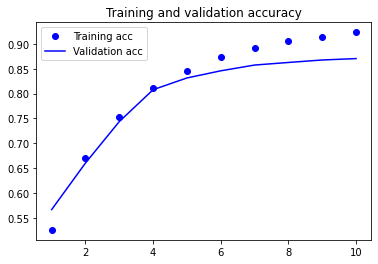

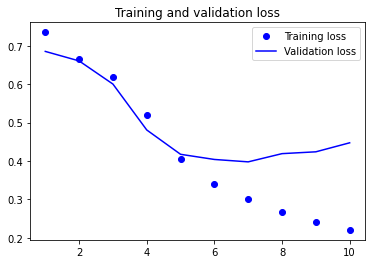

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 6.4.4 CNN(Convolutional Neural Network)과 RNN(Recurrent Neural Network)을 연결하여 긴 시퀀스를 처리하기

* 1D 컨브넷이 입력 패치를 독립적으로 처리하기 때문에 RNN과 달리 (합성곱 윈도우 크기의 범위를 넘어선) 타임스텝의 순서에 민감하지 않습니다. 물론 장기간 패턴을 인식하기 위해 많은 합성곱 층과 풀링 층을 쌓을 수 있습니다. 상위 층은 원본 입력에서 긴 범위를 보게 될 것입니다. 이런 방법은 순서를 감지하기엔 부족합니다. 온도 예측 문제에 1D 컨브넷을 적용하여 이를 확인해 보겠습니다. 이 문제는 순서를 감지해야 좋은 예측을 만들어 낼 수 있습니다. 다음은 이전에 정의한 float_data, train_gen, val_gen, val_steps를 다시 사용합니다.

In [3]:
import os
import numpy as np

data_dir = '../data/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [4]:
# 예나 데이터에서 1D 컨브넷을 훈련하고 평가하기
# Training and validating 1D convnet in the jena climate dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

c:\users\wnstj\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 50s 97ms/step - loss: 0.4117 - val_loss: 0.4818
Epoch 2/20
500/500 [==============================] - 48s 97ms/step - loss: 0.3577 - val_loss: 0.4450
Epoch 3/20
500/500 [==============================] - 49s 98ms/step - loss: 0.3353 - val_loss: 0.4366
Epoch 4/20
500/500 [==============================] - 49s 97ms/step - loss: 0.3174 - val_loss: 0.4306
Epoch 5/20
500/500 [==============================] - 50s 100ms/step - loss: 0.3042 - val_loss: 0.4615
Epoch 6/20
500/500 [==============================] - 51s 102ms/step - loss: 0.2947 - val_loss: 0.4501
Epoch 7/20
500/500 [==============================] - 49s 97ms/step - loss: 0.2849 - val_loss: 0.4509
Epoch 8/20
500/500 [==============================] - 48s 97ms/step - loss: 0.2796 - val_loss: 0.4531
Epoch 9/20
500/500 [==============================] - 49s 98ms/step - loss: 0.2718 - val_loss: 0.4452
Epoch 10/20
500/500 [==============================] - 49s 98ms/step - loss: 0.2

* 다음은 훈련 MAE와 검증 MAE입니다.

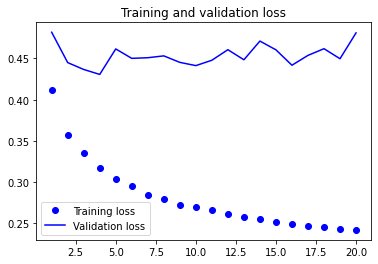

In [5]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

[1D 컨브넷을 사용한 예나 온도 예측 문제의 훈련 손실과 검증 손실(Training and validation loss of jena temperature prediction problems by using a 1D convnet)]

* 검증 MAE는 0.40 대에 머물러 있습니다. 작은 컨브넷을 사용해서 상식 수준의 기준점을 넘지 못 했습니다. 이는 컨브넷이 입력 시계열에 있는 패턴을 보고 이 패턴의 시간 축의 위치(시작인지 끝 부분인지 등)를 고려하지 않기 때문입니다. 최근 데이터 포인트일수록 오래된 데이터 포인트와는 다르게 해석해야 하기 때문에 컨브넷이 의미 있는 결과를 만들지 못합니다. 이런 컨브넷의 한계는 IMDB 데이터에서는 문제가 되지 않습니다. 긍정 또는 부정적인 감성과 연관된 키워드 패턴의 중요성은 입력 시퀀스에 나타난 위치와 무관하기 때문입니다.

* 컨브넷의 속도와 경량함을 RNN의 순서 감지 능력과 결합하는 한가지 전략은 1D 컨브넷을 RNN 이전에 전처리 단계로 사용하는 것입니다. 수천 개의 스텝을 가진 시퀀스 같이 RNN으로 처리하기엔 현실적으로 너무 긴 시퀀스를 다룰 때 특별히 도움이 됩니다. 컨브넷이 긴 입력 시퀀스를 더 짧은 고수준 특성의 (다운 샘플된) 시퀀스로 변환합니다. 추출된 특성의 시퀀스는 RNN 파트의 입력이 됩니다.

* 이 기법이 연구 논문이나 실전 애플리케이션에 자주 등장하지는 않습니다. 아마도 널리 알려지지 않았기 때문일 것입니다. 이 방법은 효과적이므로 많이 사용되기를 바랍니다. 온도 예측 문제에 적용해 보죠. 이 전략은 훨씬 긴 시퀀스를 다룰 수 있으므로 더 오래전 데이터를 바라보거나(데이터 제너레이터의 `lookback` 매개변수를 증가시킵니다), 시계열 데이터를 더 촘촘히 바라볼 수 있습니다(제너레이터의 `step` 매개변수를 감소시킵니다). 여기서는 그냥 `step`을 절반으로 줄여서 사용하겠습니다. 온도 데이터가 30분마다 1 포인트씩 샘플링되기 때문에 결과 시계열 데이터는 두 배로 길어집니다. 앞서 정의한 제너레이터 함수를 다시 사용합니다.

In [ ]:
# 고밀도 데이터 제너레이터로 예나 데이터셋 준비하기
# Preparing jena datasets with high density data generator
# 이전에는 6이었습니다(시간마다 1 포인트); 이제는 3 입니다(30분마다 1 포인트)
step = 3
lookback = 1440  # 변경 안 됨
delay = 144 # 변경 안 됨

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

* 이 모델은 두 개의 `Conv1D` 층 다음에 `GRU` 층을 놓았습니다.

In [ ]:
# 1D 합성곱과 GRU 층을 연결한 모델
# Model with linking 1D convolution and GRU layer
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)